# This file contains the codes of the paper: Metric Learning for Novel Motion Rejection in High-Density Myoelectric Pattern Recognition

In [1]:
import scipy.io as sio
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense,Dropout, Input, BatchNormalization,Embedding,Lambda
from keras.models import Model
from keras import backend as K
from keras import optimizers
from keras.losses import categorical_crossentropy
import keras
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Using TensorFlow backend.


In [2]:
# parameters
modelPath = './model/'
alpha = 0.00005 #lambda in the paper
outliers_fract = 0.1 # 1-recall

trainFlag = False #train models
# load data
path = './data/data'
data=sio.loadmat(path)

wristPronation = data['wristPronation']
wristSupination = data['wristSupination']
wristExtension = data['wristExtension']
wristFlexion = data['wristFlexion']
handOpen = data['handOpen']
handClose = data['handClose']
shoot = data['shoot']

pinch = data['pinch']
typing = data['typing']
writing = data['writing']
mouseManipulating = data['mouseManipulating']
radialDeviation = data['radialDeviation']
ulnarDeviation = data['ulnarDeviation']

## procedure 2: Describe HD-sEMG images using CNN and metric learning

In [3]:
# target motion tasks
classNum = 7
X_inliers = np.concatenate((wristPronation,wristSupination,wristExtension,wristFlexion,handOpen,handClose,shoot),axis=0)
print('X_inliers.shape: ',X_inliers.shape)
y_inliers = np.concatenate((np.ones(wristPronation.shape[0])*0,np.ones(wristSupination.shape[0])*1,
                            np.ones(wristExtension.shape[0])*2,np.ones(wristFlexion.shape[0])*3,
                            np.ones(handOpen.shape[0])*4,np.ones(handClose.shape[0])*5,
                            np.ones(shoot.shape[0])*6),axis=0)
print('y_inliers.shape: ',y_inliers.shape)

# train test split
X_train, X_test_norm, y_train, y_test_norm = train_test_split(X_inliers, y_inliers, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(X_test_norm.shape)

# novel motion tasks
X_test_outlier = np.concatenate((typing,writing,
                         mouseManipulating,pinch,radialDeviation,ulnarDeviation),axis=0)
y_test_outlier = np.concatenate((np.ones(typing.shape[0])*7,
                             np.ones(writing.shape[0])*8, 
                             np.ones(mouseManipulating.shape[0])*9,
                            np.ones(pinch.shape[0])*10,
                            np.ones(radialDeviation.shape[0])*11,np.ones(ulnarDeviation.shape[0])*12),axis=0)

X_test_all = np.concatenate((X_test_norm,X_test_outlier),axis=0)
y_test_all = np.concatenate((y_test_norm,y_test_outlier),axis=0)

X_inliers.shape:  (4070, 12, 8, 3)
y_inliers.shape:  (4070,)
(2604, 12, 8, 3)
(652, 12, 8, 3)
(814, 12, 8, 3)


In [4]:
# build and train the CNN
nb_classes = 7
feature_size = 512
y_train_value = y_train
y_train = keras.utils.to_categorical(y_train, 7)
random_y_train = np.random.rand(len(y_train_value),1)

input_image = Input(shape=(12,8,3))
cnn = Conv2D(filters=32, kernel_size=(3, 3),activation='relu',name = 'conv_layer1')(input_image)
cnn = Conv2D(filters=32, kernel_size=(3, 3), activation='relu',name = 'conv_layer2')(cnn)
cnn = Flatten()(cnn)
cnn = Dense(units=1024, activation='relu',name = 'dense_layer1')(cnn)
cnn = Dropout(0.4)(cnn)
feature = Dense(feature_size, activation='relu')(cnn)
feature = Dropout(0.4)(feature)
predict = Dense(nb_classes, activation='softmax', name='softmax')(feature) #至此，得到一个常规的softmax分类模型

input_target = Input(shape=(1,))
centers = Embedding(nb_classes, feature_size)(input_target) #Embedding层用来存放中心
l2_loss = Lambda(lambda x: K.sum(K.square(x[0]-x[1][:,0]), 1, keepdims=True), name='l2_loss')([feature,centers])
# for training 
model_train = Model(inputs=[input_image,input_target], outputs=[predict,l2_loss])

# for prediction 
model_predict = Model(inputs=input_image, outputs=predict)
model_predict.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# for extracting features
model_feature = Model(inputs=input_image, outputs=feature)
model_feature.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [5]:
optimizer = optimizers.Adadelta(lr=0.1)
model_train.compile(optimizer=optimizer,loss=['categorical_crossentropy',lambda y_true,y_pred: y_pred], loss_weights=[1.,alpha], metrics={'softmax':'accuracy'})
if trainFlag:
    model_train.fit([X_train,y_train_value], [y_train,random_y_train], epochs=50)
    optimizer = optimizers.Adadelta(lr=0.01)
    model_train.compile(optimizer=optimizer,loss=['categorical_crossentropy',lambda y_true,y_pred: y_pred], loss_weights=[1.,alpha], metrics={'softmax':'accuracy'})
    model_train.fit([X_train,y_train_value], [y_train,random_y_train], epochs=50)
    # save models
    model_train.save_weights(modelPath+'/CNN_model_train.h5')
    model_predict.save_weights(modelPath+'/CNN_model_predict.h5')
    model_feature.save_weights(modelPath+'/CNN_model_feature.h5')
else:
    model_train.load_weights(modelPath+'/CNN_model_train.h5')
    model_predict.load_weights(modelPath+'/CNN_model_predict.h5')
    model_feature.load_weights(modelPath+'/CNN_model_feature.h5')

In [6]:
#get representations using CNN

def getPointedGesture(X,y,flag):
    index = np.where(y==flag)
    temp = X[index]
    return temp

X_train_feature = model_feature.predict(X_train)
X_test_feature = model_feature.predict(X_test_all)
X_val_fearure = model_feature.predict(X_val)

## train Data
wristPronation_intermediate_train = getPointedGesture(X_train_feature,y_train_value,0)
wristSupination_intermediate_train = getPointedGesture(X_train_feature,y_train_value,1)
wristExtension_intermediate_train = getPointedGesture(X_train_feature,y_train_value,2)
wristFlexion_intermediate_train = getPointedGesture(X_train_feature,y_train_value,3)
handOpen_intermediate_train = getPointedGesture(X_train_feature,y_train_value,4)
handClose_intermediate_train = getPointedGesture(X_train_feature,y_train_value,5)
shoot_intermediate_train = getPointedGesture(X_train_feature,y_train_value,6)

## test data
wristPronation_intermediate_test = getPointedGesture(X_test_feature,y_test_all,0)
wristSupination_intermediate_test = getPointedGesture(X_test_feature,y_test_all,1)
wristExtension_intermediate_test = getPointedGesture(X_test_feature,y_test_all,2)
wristFlexion_intermediate_test = getPointedGesture(X_test_feature,y_test_all,3)
handOpen_intermediate_test = getPointedGesture(X_test_feature,y_test_all,4)
handClose_intermediate_test = getPointedGesture(X_test_feature,y_test_all,5)
shoot_intermediate_test = getPointedGesture(X_test_feature,y_test_all,6)

typing_intermediate_test = getPointedGesture(X_test_feature,y_test_all,7)
writing_intermediate_test = getPointedGesture(X_test_feature,y_test_all,8)
mouseManipulating_intermediate_test = getPointedGesture(X_test_feature,y_test_all,9)
pinch_intermediate_test = getPointedGesture(X_test_feature,y_test_all,10)
radialDeviation_intermediate_test = getPointedGesture(X_test_feature,y_test_all,11)
ulnarDeviation_intermediate_test = getPointedGesture(X_test_feature,y_test_all,12)

outlierData = {'typing_intermediate_test':typing_intermediate_test,
               'writing_intermediate_test':writing_intermediate_test,
               'mouseManipulating_intermediate_test':mouseManipulating_intermediate_test,
              'pinch_intermediate_test':pinch_intermediate_test}

motionNameList = ['wristPronation','wristSupination','wristExtension','wristFlexion','handOpen','handClose','shoot']
trainDataDict = {motionNameList[0]:wristPronation_intermediate_train,motionNameList[1]:wristSupination_intermediate_train,
                 motionNameList[2]:wristExtension_intermediate_train,motionNameList[3]:wristFlexion_intermediate_train,
                 motionNameList[4]:handOpen_intermediate_train,motionNameList[5]:handClose_intermediate_train,
            motionNameList[6]:shoot_intermediate_train}
testDataNameList = ['wristPronation','wristSupination','wristExtension','wristFlexion','handOpen','handClose','shoot',
                    'typing','writing','mouseManipulating','pinch','radialDeviation','ulnarDeviation']
outlierBegin = 0
outlierEnd = 300
testDataDict = {testDataNameList[0]:wristPronation_intermediate_test,testDataNameList[1]:wristSupination_intermediate_test,
                testDataNameList[2]:wristExtension_intermediate_test,testDataNameList[3]:wristFlexion_intermediate_test,
                testDataNameList[4]:handOpen_intermediate_test,testDataNameList[5]:handClose_intermediate_test,
                testDataNameList[6]:shoot_intermediate_test,testDataNameList[7]:typing_intermediate_test[outlierBegin:outlierEnd],
                testDataNameList[8]:writing_intermediate_test[outlierBegin:outlierEnd],testDataNameList[9]:mouseManipulating_intermediate_test[outlierBegin:outlierEnd],
                testDataNameList[10]:pinch_intermediate_test[outlierBegin:outlierEnd],testDataNameList[11]:radialDeviation_intermediate_test[outlierBegin:outlierEnd],
               testDataNameList[12]:ulnarDeviation_intermediate_test[outlierBegin:outlierEnd]}
# val data
wristPronation_intermediate_val = getPointedGesture(X_val_fearure,y_val,0)
wristSupination_intermediate_val = getPointedGesture(X_val_fearure,y_val,1)
wristExtension_intermediate_val = getPointedGesture(X_val_fearure,y_val,2)
wristFlexion_intermediate_val = getPointedGesture(X_val_fearure,y_val,3)
handOpen_intermediate_val = getPointedGesture(X_val_fearure,y_val,4)
handClose_intermediate_val = getPointedGesture(X_val_fearure,y_val,5)
shoot_intermediate_val = getPointedGesture(X_val_fearure,y_val,6)

valDataDict = {motionNameList[0]:wristPronation_intermediate_val,motionNameList[1]:wristSupination_intermediate_val,
               motionNameList[2]:wristExtension_intermediate_val,motionNameList[3]:wristFlexion_intermediate_val,
               motionNameList[4]:handOpen_intermediate_val,motionNameList[5]:handClose_intermediate_val,
            motionNameList[6]:shoot_intermediate_val}

## Procedure 3: Reject novel samples using AE

In [7]:
from keras import regularizers
from keras.losses import mean_squared_error
from keras.optimizers import SGD

def autoModel(input_shape):
    input_img = Input(input_shape)
    encoded = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.002))(input_img)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.002))(encoded)
    encoded = BatchNormalization()(encoded)
    decoded = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.002))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.002))(decoded)
    model = Model(input_img, decoded)
    return model

In [8]:
if trainFlag:
    for motionId in range(len(motionNameList)):
        motionName = motionNameList[motionId]
        print(motionName)
        x_train = trainDataDict[motionName]
        x_val = valDataDict[motionName]
        autoencoder = autoModel((512,))
        autoencoder.compile(loss=mean_squared_error, optimizer=SGD(lr=0.1))
        autoencoder.fit(x_train, x_train,
                        epochs=600,
                        batch_size=16,
                        shuffle=True,
                        validation_data=(x_val, x_val))

        autoencoder.compile(loss=mean_squared_error, optimizer=SGD(lr=0.01))
        autoencoder.fit(x_train, x_train,
                        epochs=300,
                        batch_size=16,
                        shuffle=True,
                        validation_data=(x_val, x_val))
        autoencoder.save_weights(modelPath+'/'+'Autoencoder_'+motionName+'.h5')

In [9]:
# input feature representations, output predictions
# model_predict.summary()
input_layer = Input((512,))
predict = model_predict.layers[-1](input_layer)
model_512 = Model(inputs=input_layer,outputs=predict)

In [10]:
# calculate reconstruction errors with the validation dataset
targetDict = {}
for motionId in range(len(motionNameList)):
    targetList = []
    motionName = motionNameList[motionId]
    print('motionName: ', motionName)
    # load models
    autoencoder = autoModel((512,))
    autoencoder.compile(loss=mean_squared_error, optimizer=SGD(lr=0.1))
    autoencoder.load_weights(modelPath+'/'+'Autoencoder_'+motionName+'.h5') 
    original = valDataDict[motionName]
    decoded_imgs = autoencoder.predict(original)
    num = decoded_imgs.shape[0]
    for i in range(num):
        X = np.vstack([original[i,:],decoded_imgs[i,:]])
        lose = pdist(X,'braycurtis')
        targetList.append(lose[0])
    targetDict[motionName] = targetList

motionName:  wristPronation
motionName:  wristSupination
motionName:  wristExtension
motionName:  wristFlexion
motionName:  handOpen
motionName:  handClose
motionName:  shoot


In [11]:
mdDict = {}
for motionId in range(len(motionNameList)):
    motionName = motionNameList[motionId]
    print('motionName: ', motionName)
    # load models
    autoencoder = autoModel((512,))
    autoencoder.compile(loss=mean_squared_error, optimizer=SGD(lr=0.1))
    autoencoder.load_weights(modelPath+'/'+'Autoencoder_'+motionName+'.h5')
    originalDict = {}
    decodedDict = {}
    for gestureId in range(len(testDataNameList)):
        originalDict[testDataNameList[gestureId]] = testDataDict[testDataNameList[gestureId]]
        decodedDict[testDataNameList[gestureId]] = autoencoder.predict(originalDict[testDataNameList[gestureId]])

    reconstruction_error = []
    for gestureID in range(len(testDataNameList)):
        original = originalDict[testDataNameList[gestureID]]
        decoded_imgs = decodedDict[testDataNameList[gestureID]]
        num = decoded_imgs.shape[0]
        for i in range(num):
            X = np.vstack([original[i,:],decoded_imgs[i,:]])
            lose = pdist(X,'braycurtis')
            reconstruction_error.append(lose[0])
    mdDict[motionName] = reconstruction_error

motionName:  wristPronation
motionName:  wristSupination
motionName:  wristExtension
motionName:  wristFlexion
motionName:  handOpen
motionName:  handClose
motionName:  shoot


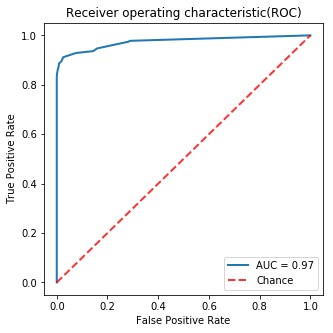

In [12]:
# ROC curve
outlierAllNum = (outlierEnd-outlierBegin) * 6 
y_label = []
for motionId in range(len(motionNameList)):
    motionName = motionNameList[motionId]
    y_label.extend(np.ones(len(testDataDict[motionName])))
y_label.extend(np.zeros(len(testDataDict['typing'])))
y_label.extend(np.zeros(len(testDataDict['writing'])))
y_label.extend(np.zeros(len(testDataDict['mouseManipulating'])))
y_label.extend(np.zeros(len(testDataDict['pinch'])))
y_label.extend(np.zeros(len(testDataDict['radialDeviation'])))
y_label.extend(np.zeros(len(testDataDict['radialDeviation'])))

outliers_fraction_List = []
P_List = []
R_List = []
F1_List = []
TPR_List = []
FPR_List = []
predict_CNN = []
for gestureId in range(len(testDataNameList)):
# gestureId = 0
    gestureName = testDataNameList[gestureId]
    data = testDataDict[gestureName]
    y_class_predict = model_512.predict(data)
    y_class_predict_argmax = np.argmax(y_class_predict,axis=-1)
    predict_CNN.extend(y_class_predict_argmax.tolist())

# outliers_i = 50
for outliers_i in range(-1,101):
    outliers_fraction = outliers_i/100
    outliers_fraction_List.append(outliers_fraction)



    thresholdDict = {}
    for motionId in range(len(motionNameList)):
    #    motionId = 0
        motionName = motionNameList[motionId]
        distances = targetDict[motionName]
        distances = np.sort(distances)
        num = len(distances)
    #        print('outliers_fraction:',outliers_fraction)
        if outliers_fraction >= 0:
            threshold = distances[num-1-int(outliers_fraction*num)]# get threshold
        if outliers_fraction < 0:
            threshold = 10000.0
        if outliers_fraction == 1.0:
            threshold = 0
        thresholdDict[motionName] = threshold 
    # 针对当下阈值,计算y
    y_pred = np.zeros(len(y_label))
    for numid in range(len(predict_CNN)):
        cnnMotionName = motionNameList[predict_CNN[numid]]
        threshold = thresholdDict[cnnMotionName]
        realDist = mdDict[cnnMotionName][numid]
        out_pred = (realDist<threshold)*1
        y_pred[numid] = out_pred

    
    
    TP = np.sum(y_pred[0:-outlierAllNum])
    FN = len(y_pred[0:-outlierAllNum])-TP
    FP = np.sum(y_pred[-outlierAllNum:])
    TN = outlierAllNum - FP
    t = 0.00001
    P = TP/(TP+FP+t)
    R = TP/(TP+FN+t)
    F1 = 2*P*R/(P+R+t)
    TPR = TP/(TP+FN+t)
    FPR = FP/(TN+FP+t)

    P_List.append(P)
    R_List.append(R)
    F1_List.append(F1)
    TPR_List.append(TPR)
    FPR_List.append(FPR)

roc_auc = auc(FPR_List, TPR_List)  
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(FPR_List, TPR_List, lw=2,label='AUC = %0.2f' % ( roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC)')
plt.legend(loc="lower right")
plt.show()

In [13]:
# classification accuracies under fixed recall factor
outliers_fraction = outliers_fract
thresholdDict = {}
for motionId in range(len(motionNameList)):
    motionName = motionNameList[motionId]
    distances = targetDict[motionName]
    distances = np.sort(distances)
    num = len(distances)
    if outliers_fraction >= 0:
        threshold = distances[num-1-int(outliers_fraction*num)]# get threshold
    if outliers_fraction < 0:
        threshold = 10000.0
    if outliers_fraction == 1.0:
        threshold = 0
    thresholdDict[motionName] = threshold 
y_pred = np.zeros(len(y_label))
for numid in range(len(predict_CNN)):
    cnnMotionName = motionNameList[predict_CNN[numid]]
    threshold = thresholdDict[cnnMotionName]
    realDist = mdDict[cnnMotionName][numid]
    out_pred = (realDist<threshold)*1
    y_pred[numid] = out_pred

{'wristPronation': 0.1103448275862069, 'wristSupination': 0.15966386554621848, 'wristExtension': 0.13675213675213677, 'wristFlexion': 0.20869565217391303, 'handOpen': 0.11538461538461539, 'handClose': 0.12903225806451613, 'shoot': 0.18181818181818182, 'typing': 0.0, 'writing': 0.006666666666666667, 'mouseManipulating': 0.0033333333333333335, 'pinch': 0.0033333333333333335, 'radialDeviation': 0.0, 'ulnarDeviation': 0.0, 'target overall': 0.14864864864864866}


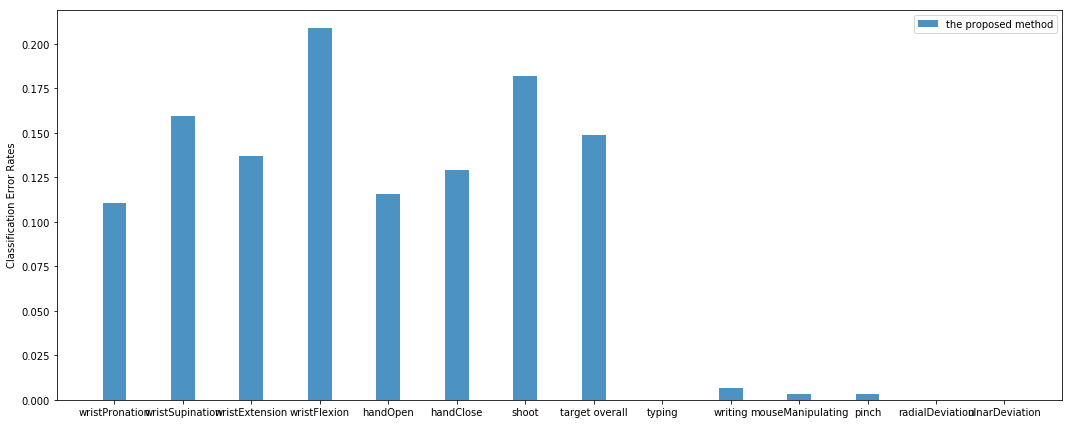

In [15]:
errorSum = 0
testSum = 0
barDict = {}
outlierClass = 6
rejectMotion = {}

#  统计识别率
count = 0
for motionId in range(len(testDataNameList)):
    motionName = testDataNameList[motionId]
    data_count = testDataDict[motionName].shape[0]
    recogArray = y_pred[count:count+data_count]
    rejectMotion[motionName] = recogArray
    if motionId<(len(testDataNameList)-outlierClass):
        numError = np.sum(1-recogArray)
    else:
        numError = np.sum(recogArray)
    numTarget = len(recogArray)
    if motionId<(len(testDataNameList)-outlierClass):
        errorSum = errorSum + numError
        testSum = testSum + numTarget
    barDict[motionName] = (numError/numTarget)
    
    count += data_count
barDict['target overall'] = errorSum/testSum
print(barDict)

figure(num=None, figsize=(15, 6))

objects = ('wristPronation','wristSupination','wristExtension','wristFlexion','handOpen','handClose','shoot','target overall',
           'typing','writing','mouseManipulating','pinch','radialDeviation','ulnarDeviation')
y_pos = np.arange(len(objects))
proposed = []
for i in range(len(objects)):
    proposed.append(barDict[objects[i]])
bar_width = 0.35
opacity = 0.8
rects2 = plt.bar(y_pos + bar_width, proposed, bar_width,
alpha=opacity,
label='the proposed method')


plt.xticks(y_pos + bar_width, objects)
plt.ylabel('Classification Error Rates')
plt.legend()
plt.tight_layout()
plt.show()